## Experiment with benchmark datasets


In [1]:
import os
import sys

import tqdm
import numpy as np
import scipy as sp
import torch
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, confusion_matrix, adjusted_rand_score

import seaborn as sns
import matplotlib.pyplot as plt

from graphkke.algorithm import m_graphkke
import graphkke.algorithm.kernels as kernels
import graphkke.graph.graph as gl

In [2]:
# Path to the data
inputdir = '/home/katerynam/work/GraphLib/data/benchmark/'

In [3]:
# Load the data
data = '5DynG-200/'

data_points = np.load(inputdir + data + 'node_points.npy')
sim_trajs = np.load(inputdir + data + 'traj.npy')
adj_matrix = np.load(inputdir + data + 'graphs.npy')
labels = np.load(inputdir + data + 'graph_states.npy')

# Create a folder where to save the result
outdir = f'/home/katerynam/work/GraphLib/data/benchmark/{data}/result/'
if not os.path.exists(outdir):
    os.mkdir(outdir)

In [4]:
# Geneerate node labels vector
num_nodes = adj_matrix.shape[0]
node_labels = list(range(1, num_nodes+1))

# Convert numpy array to graph type
graphs = []
for graph in tqdm.tqdm(adj_matrix):
    graph = gl.Graph(graph)
    graph.add_node_labels(node_labels)

    graphs.append(graph)

100%|██████████| 1000/1000 [00:20<00:00, 47.89it/s]


1
Computing WlKernel kernel...


/home/katerynam/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/home/katerynam/anaconda3/lib/python3.7/site-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


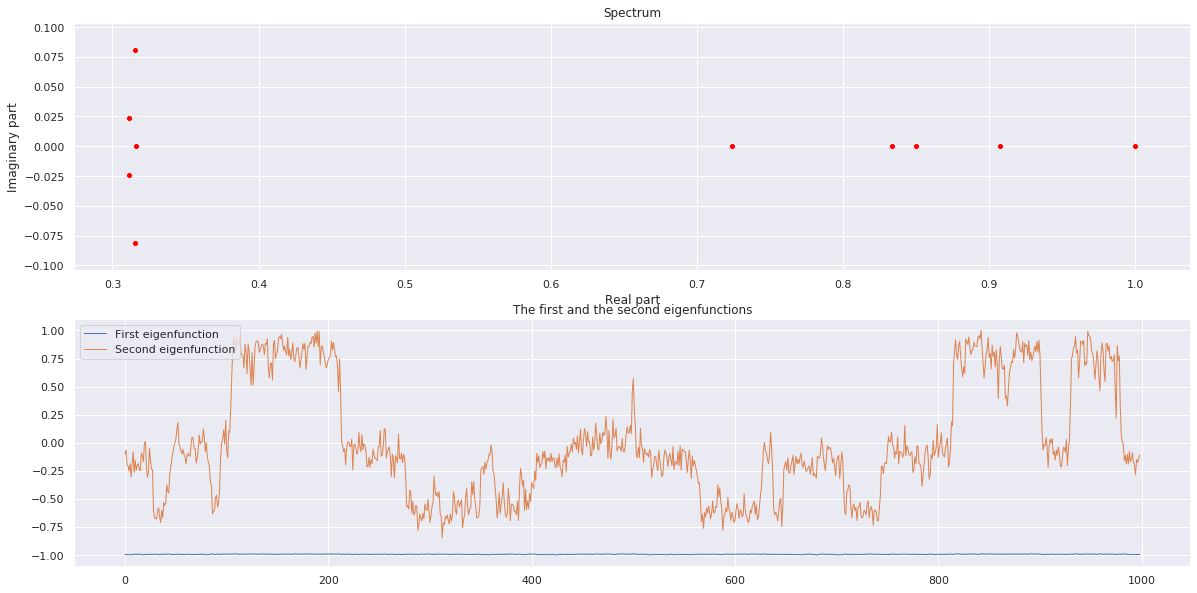

In [5]:
# Hyperparameters of graphKKE
epsilon = 0.1
operator = 'K'
k = kernels.WlKernel(1)

# Run graphKKE
m_graphkke.graphkke(graphs, k, tau=1, epsilon=epsilon, outdir=outdir)

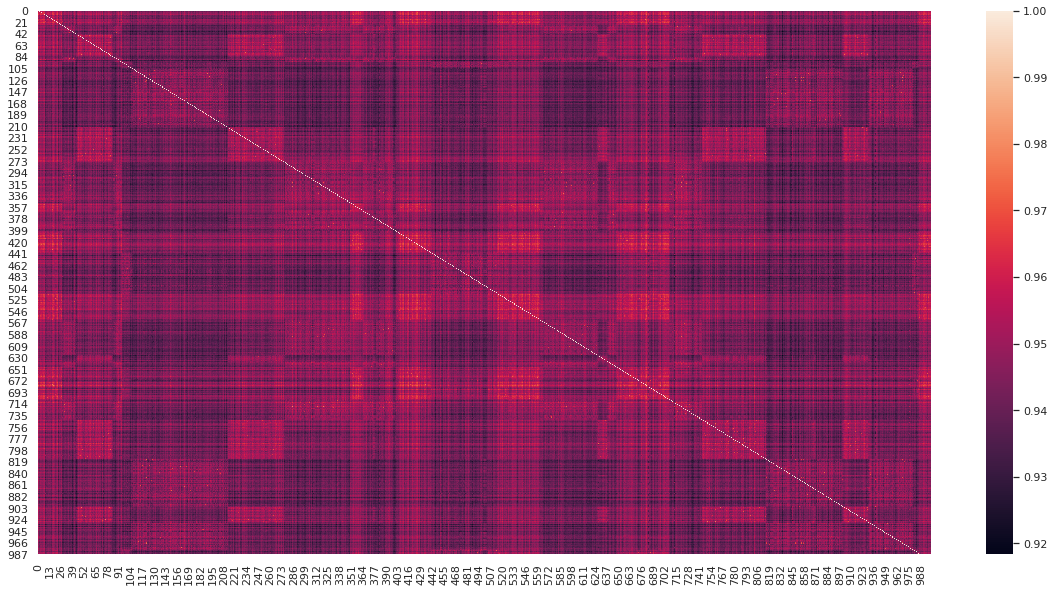

In [6]:
# Load saved metrics
d = np.load(outdir
            + 'eigenvalues.npy')
V = np.load(outdir
            + 'eigenvectors.npy')
G_xx = np.load(outdir
               + 'gramm.npy')

sns.heatmap(G_xx)

In [9]:
# Compute ARI
epochs = 30
aris = []
for i in range(epochs):
    kmeans = KMeans(n_clusters=5).fit(np.real(V[:, :5]))
    aris.append(adjusted_rand_score(labels[:-1], kmeans.labels_) * 100)

print("Mean: ", np.mean(aris))
print("STD: ", np.std(aris))

Mean:  94.31580262660964
STD:  0.0


In [10]:
# Average over graphs form one state
kmeans = KMeans(n_clusters=5).fit(np.real(V[:, :5]))
graph_l = kmeans.labels_

avg_graphs = []
unique_labels = np.unique(graph_l)
for label in unique_labels:
    ind = np.argwhere(graph_l == label).flatten()
    one_avg_graph = np.mean(adj_matrix[ind, :], axis = 0)
    avg_graphs.append(one_avg_graph)
avg_graphs = np.array(avg_graphs)

1
1
1
1
1


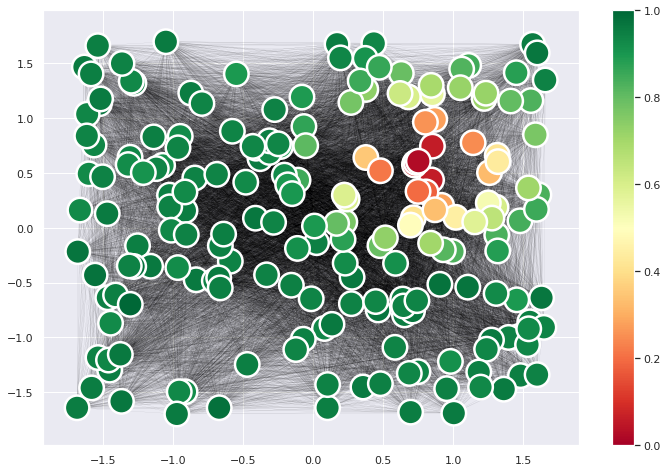

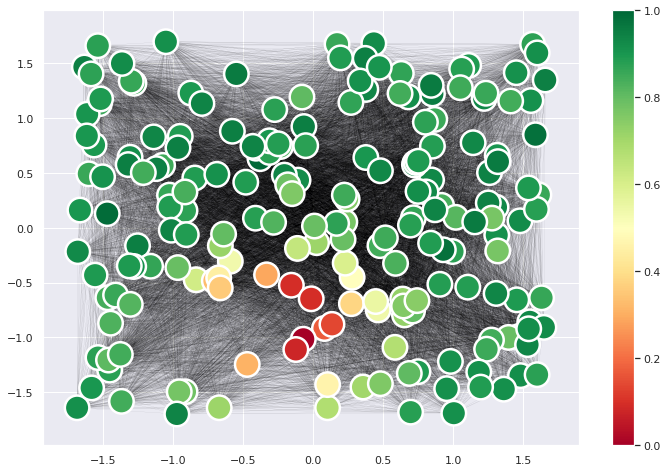

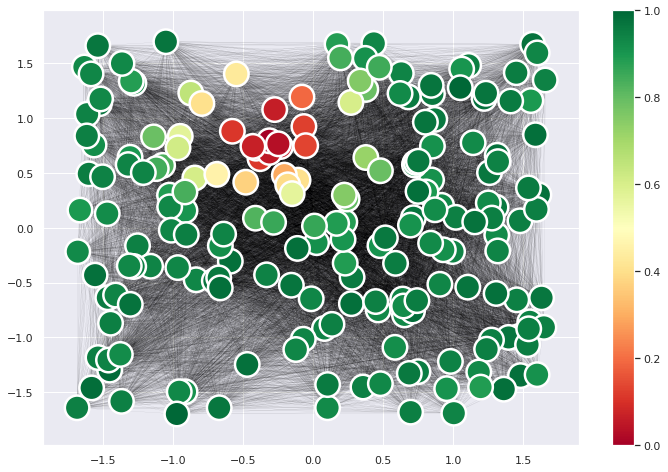

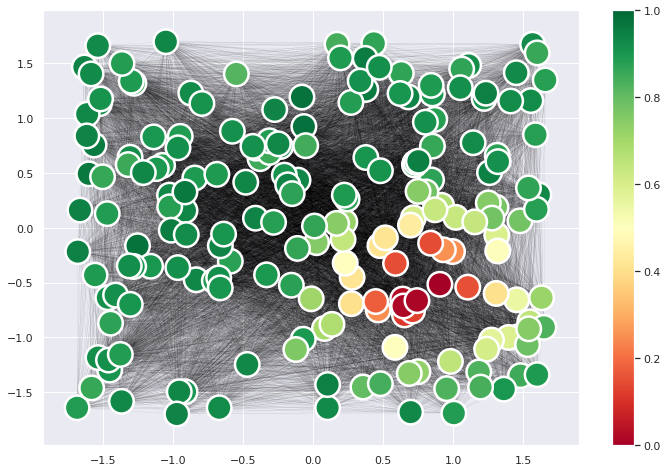

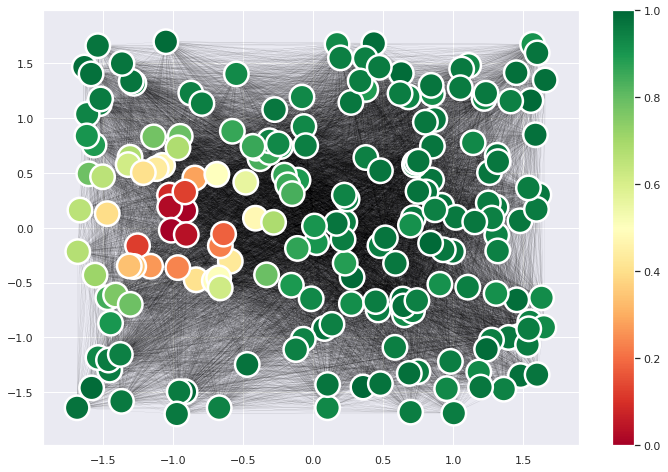

In [11]:
# Plot avgerage graphs
import itertools
sns.set(rc={'figure.figsize': (12, 8)})
x = data_points[:, 0]
y = data_points[:, 1]

x0 = [pair[0] for pair in list(itertools.combinations(x, 2))]
x1 = [pair[1] for pair in list(itertools.combinations(x, 2))]
y0 = [pair[0] for pair in list(itertools.combinations(y, 2))]
y1 = [pair[1] for pair in list(itertools.combinations(y, 2))]

for i, graph in enumerate(avg_graphs):
    fig, ax = plt.subplots()
    
    sum_nodes = np.sum(graph, axis=0).tolist()
    cmap = plt.cm.RdYlGn
    plt.plot((x0, x1), (y0, y1), color='black', lw=0.1, alpha=0.3, zorder=1)
    g = sns.scatterplot(x, y, hue=sum_nodes, palette=cmap,
                    s=600, linewidth=2.5, zorder=2)
    
    g.legend_.remove()
    sm = plt.cm.ScalarMappable(cmap=cmap)
    sm.set_array([])
    cbar = fig.colorbar(sm, ax=ax)

    plt.savefig(os.path.join(outdir, f'prob_cluster_{i}.png'), bbox_inches='tight')